In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "figure.dpi": 300
})



from Finite_volume_method_1D import *

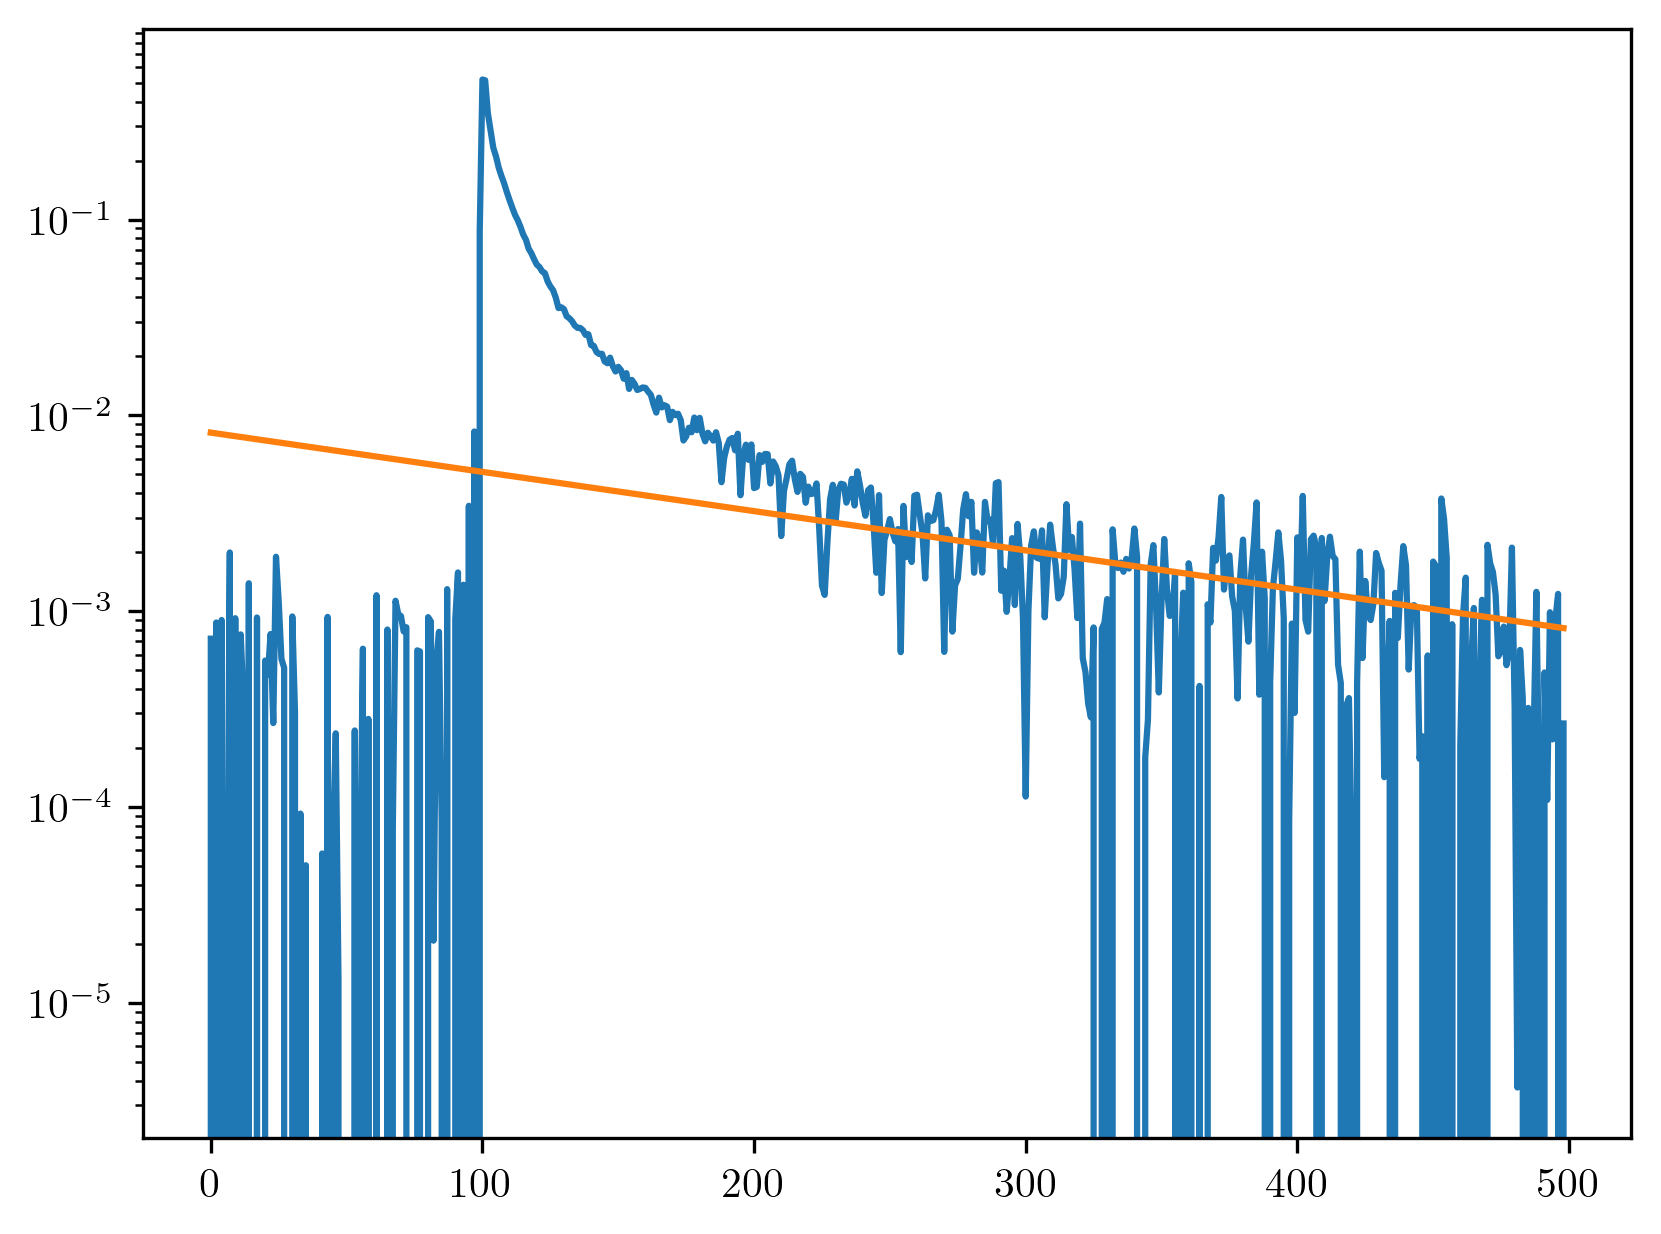

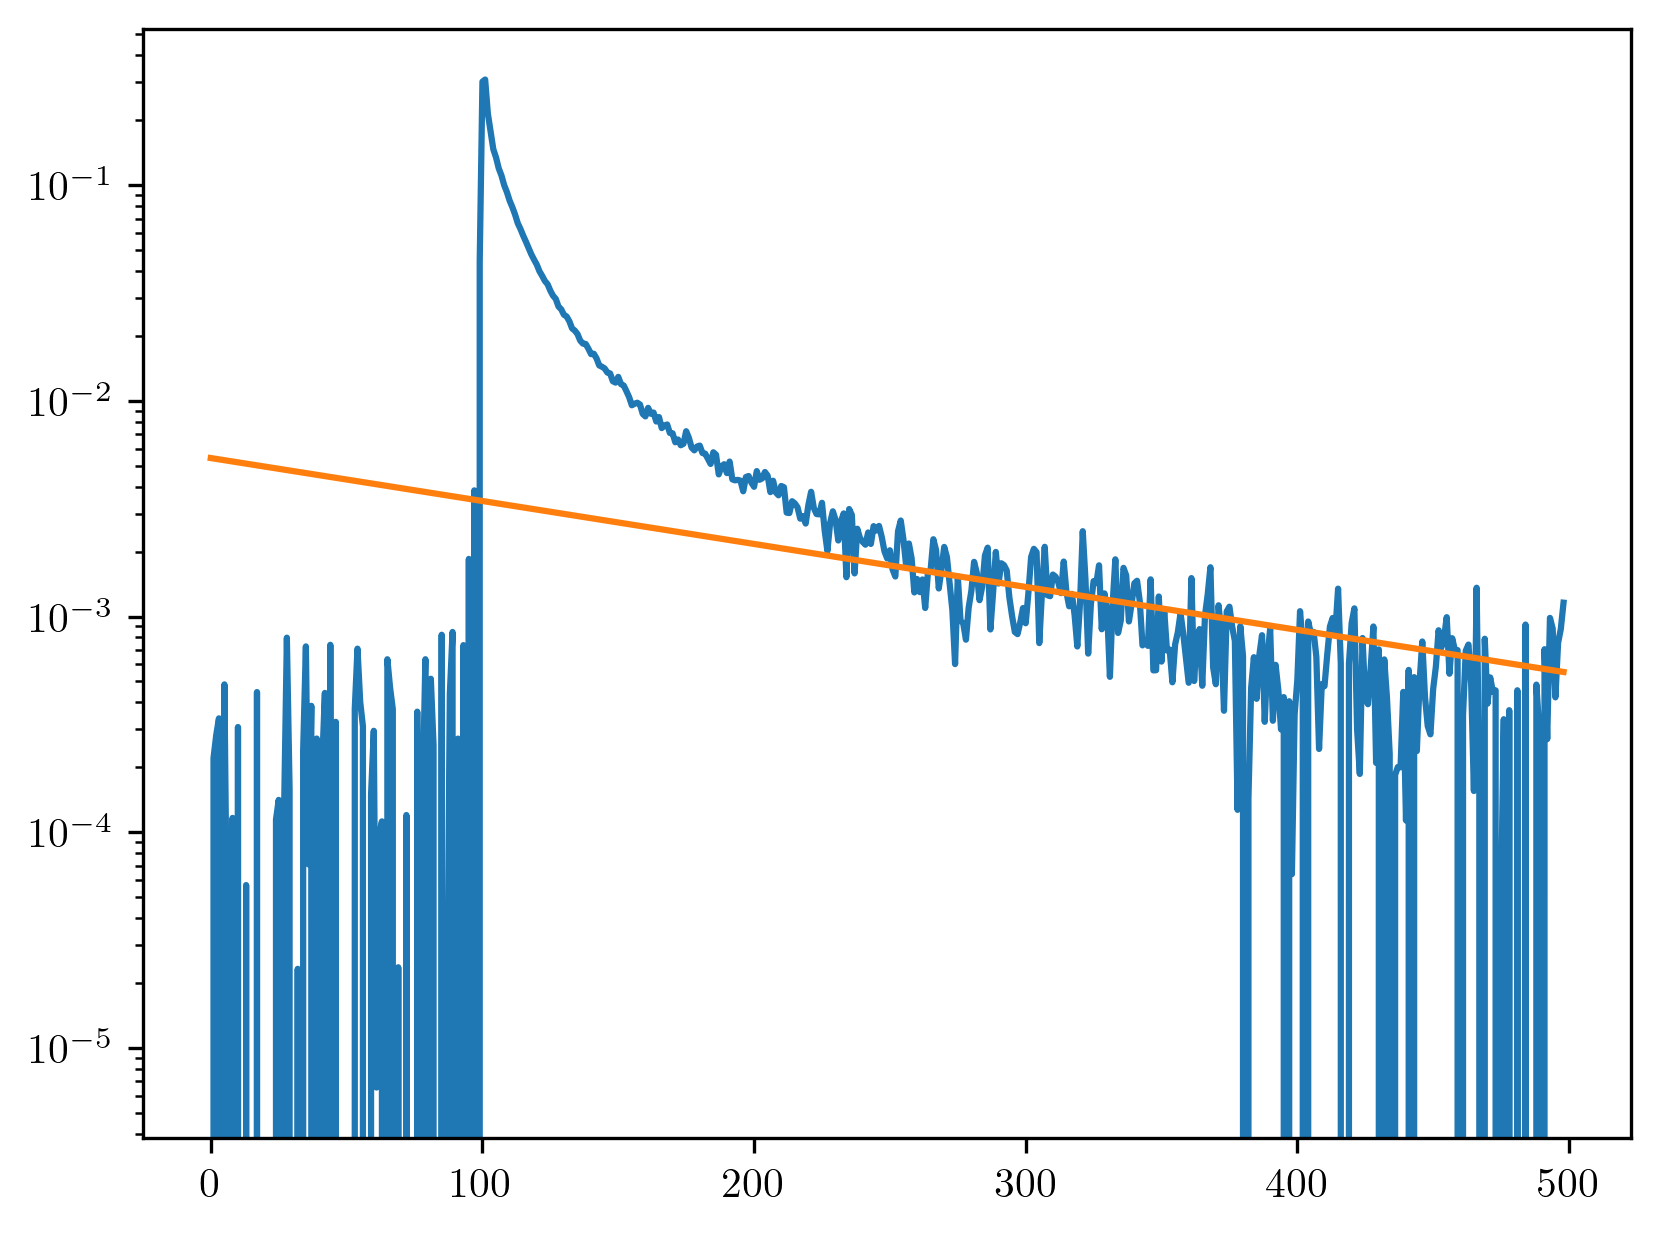

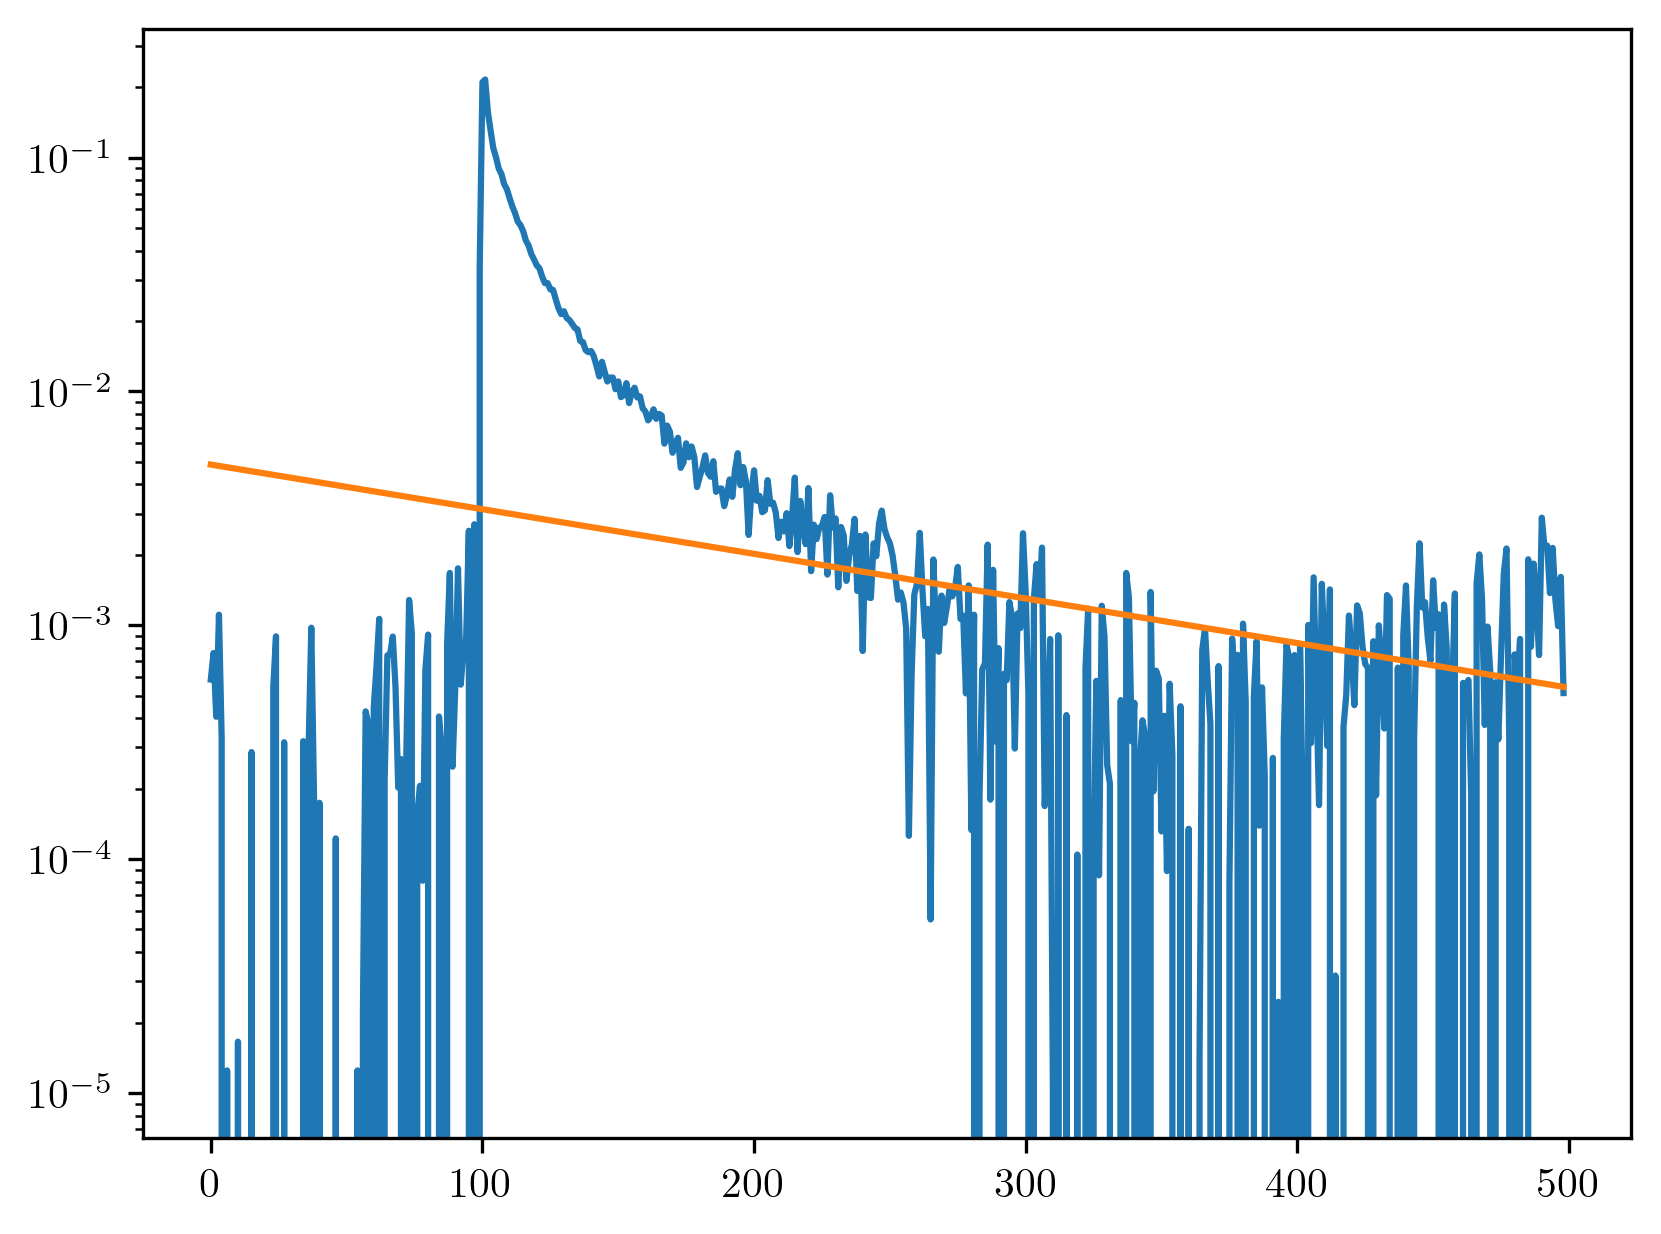

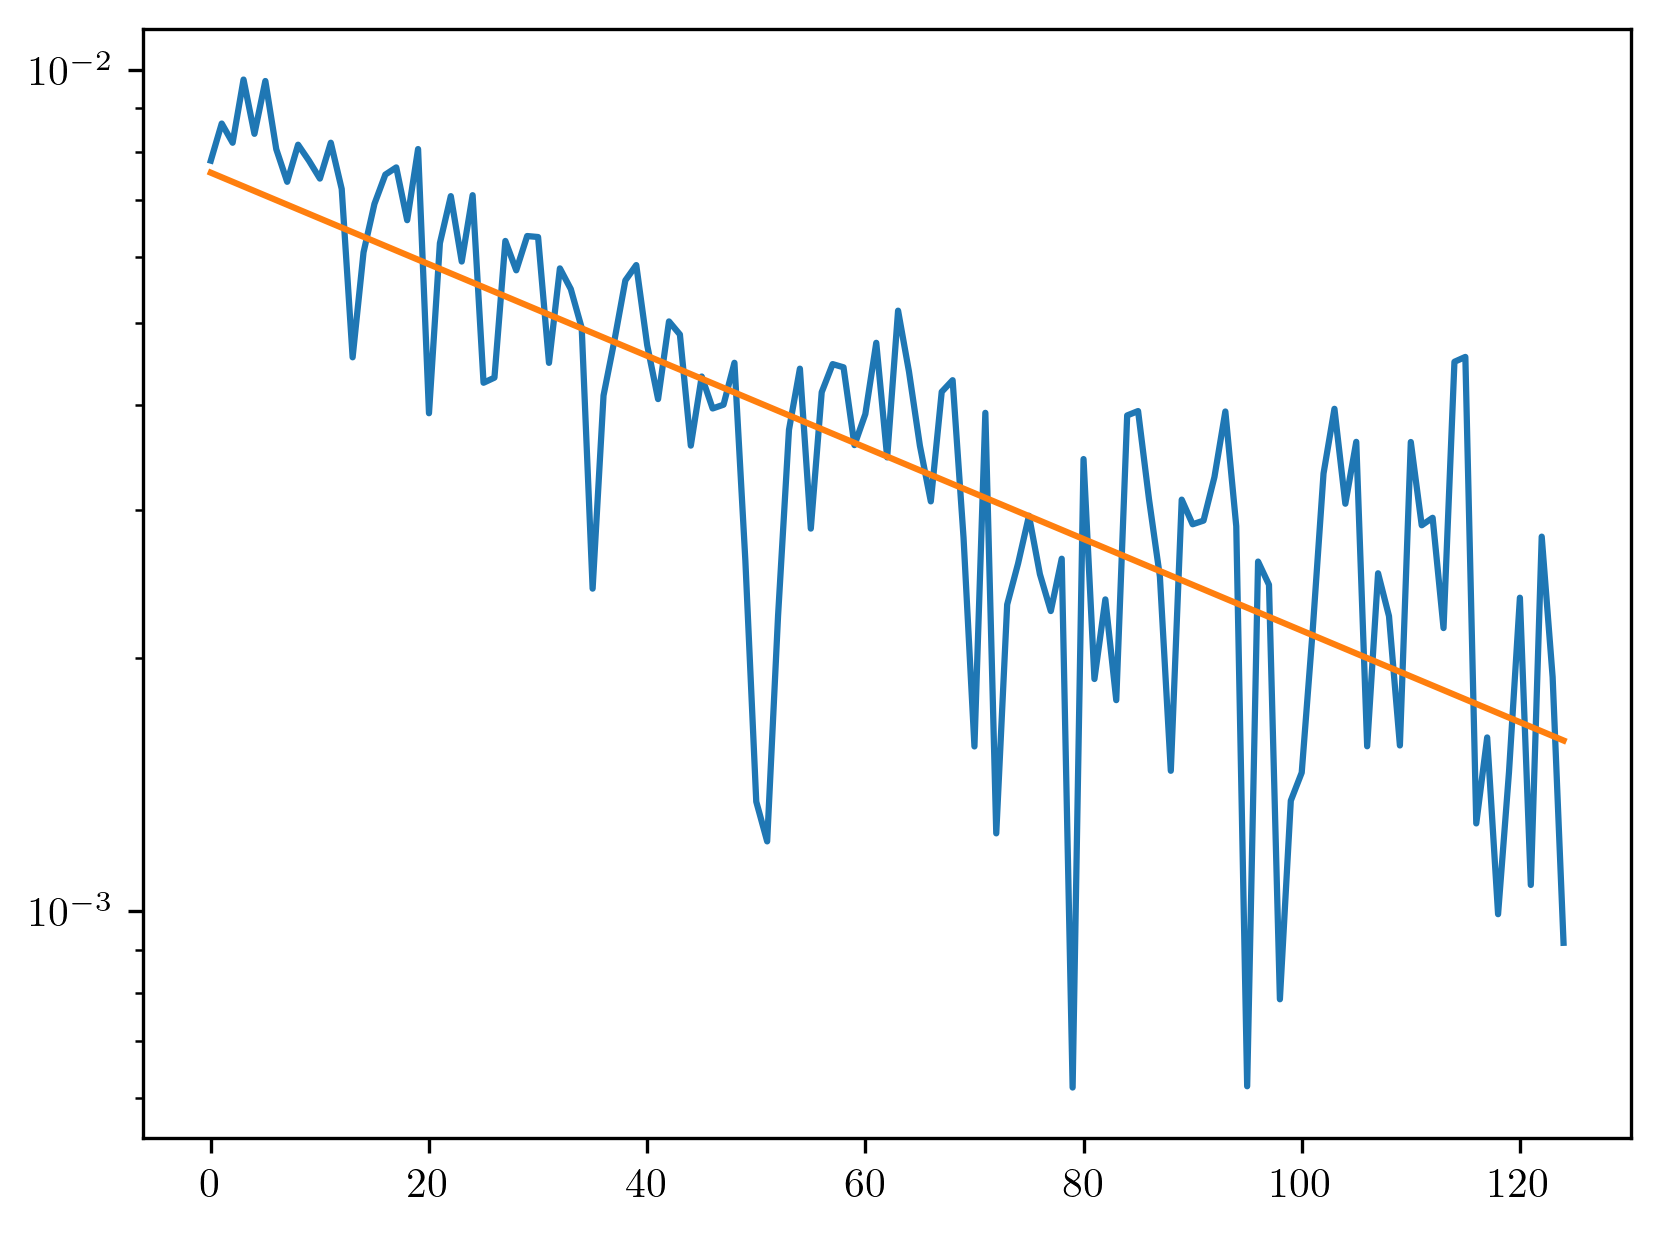

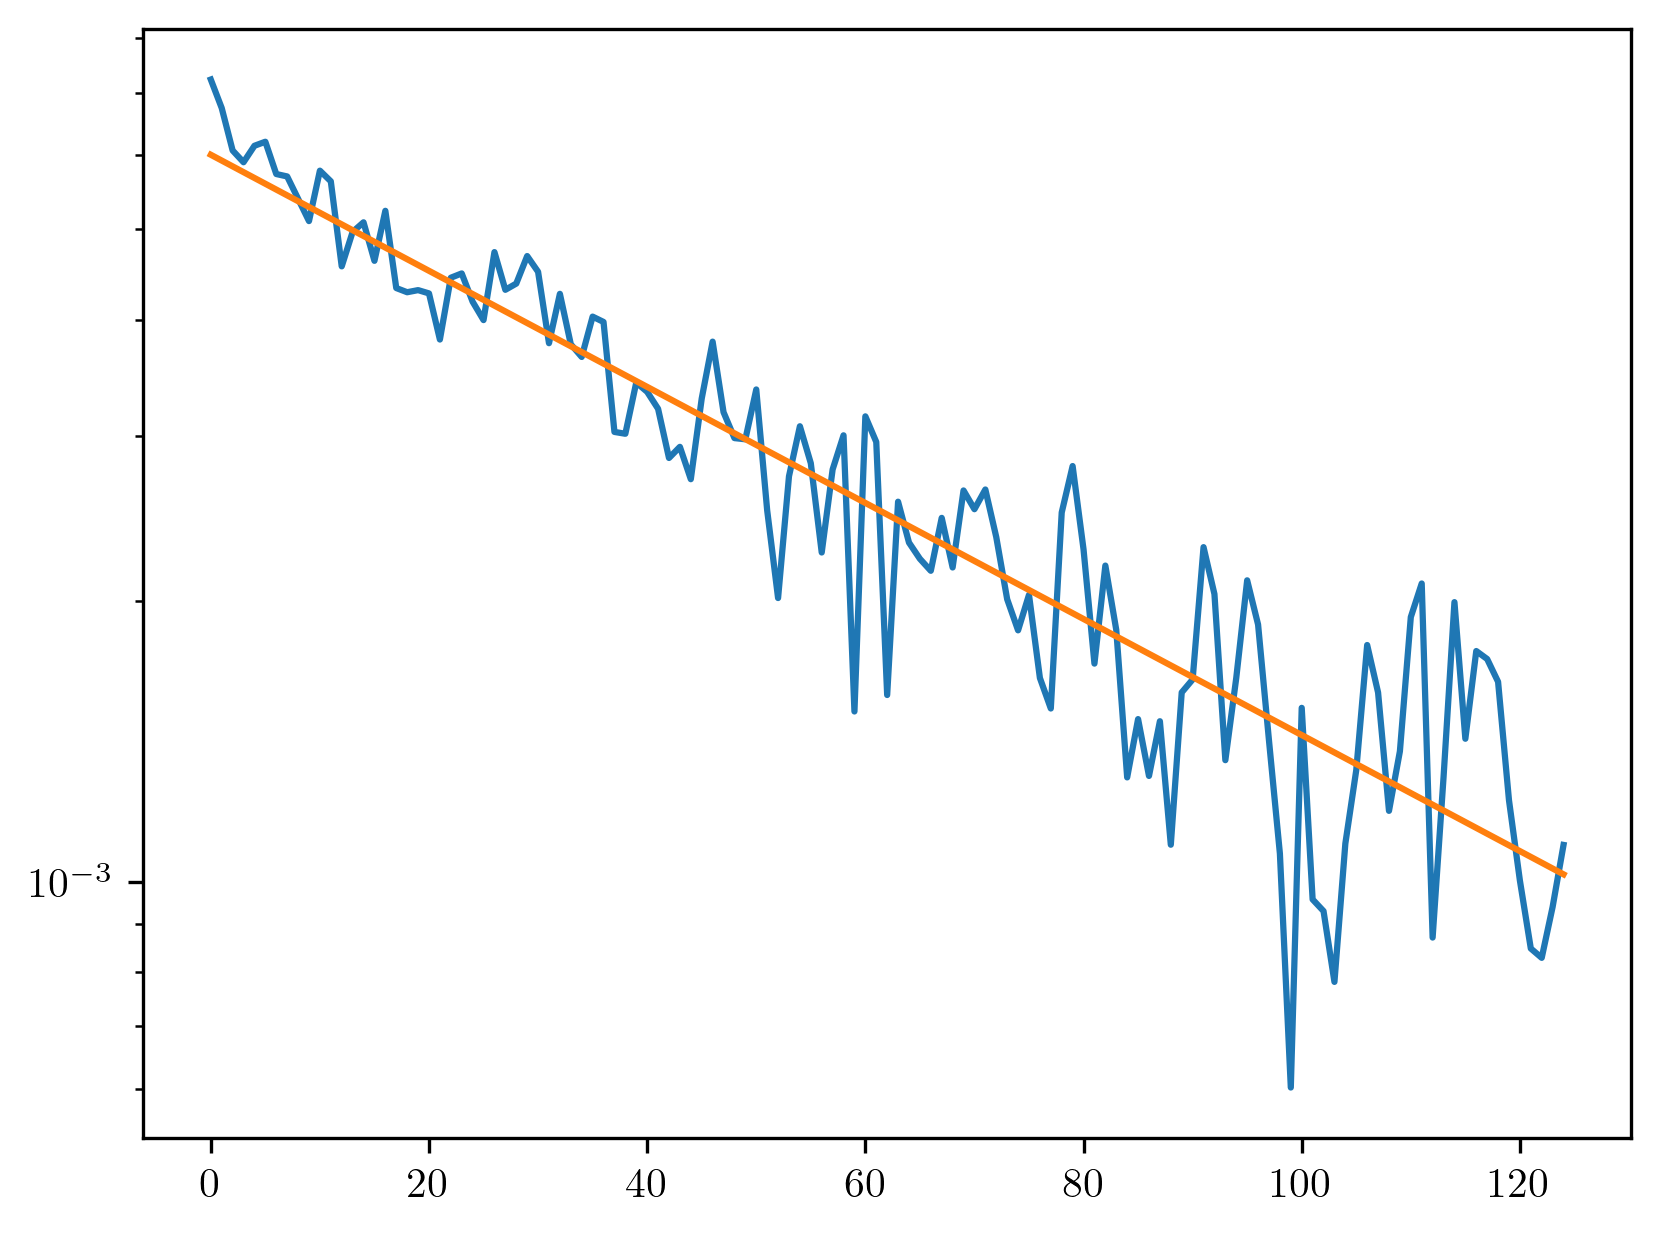

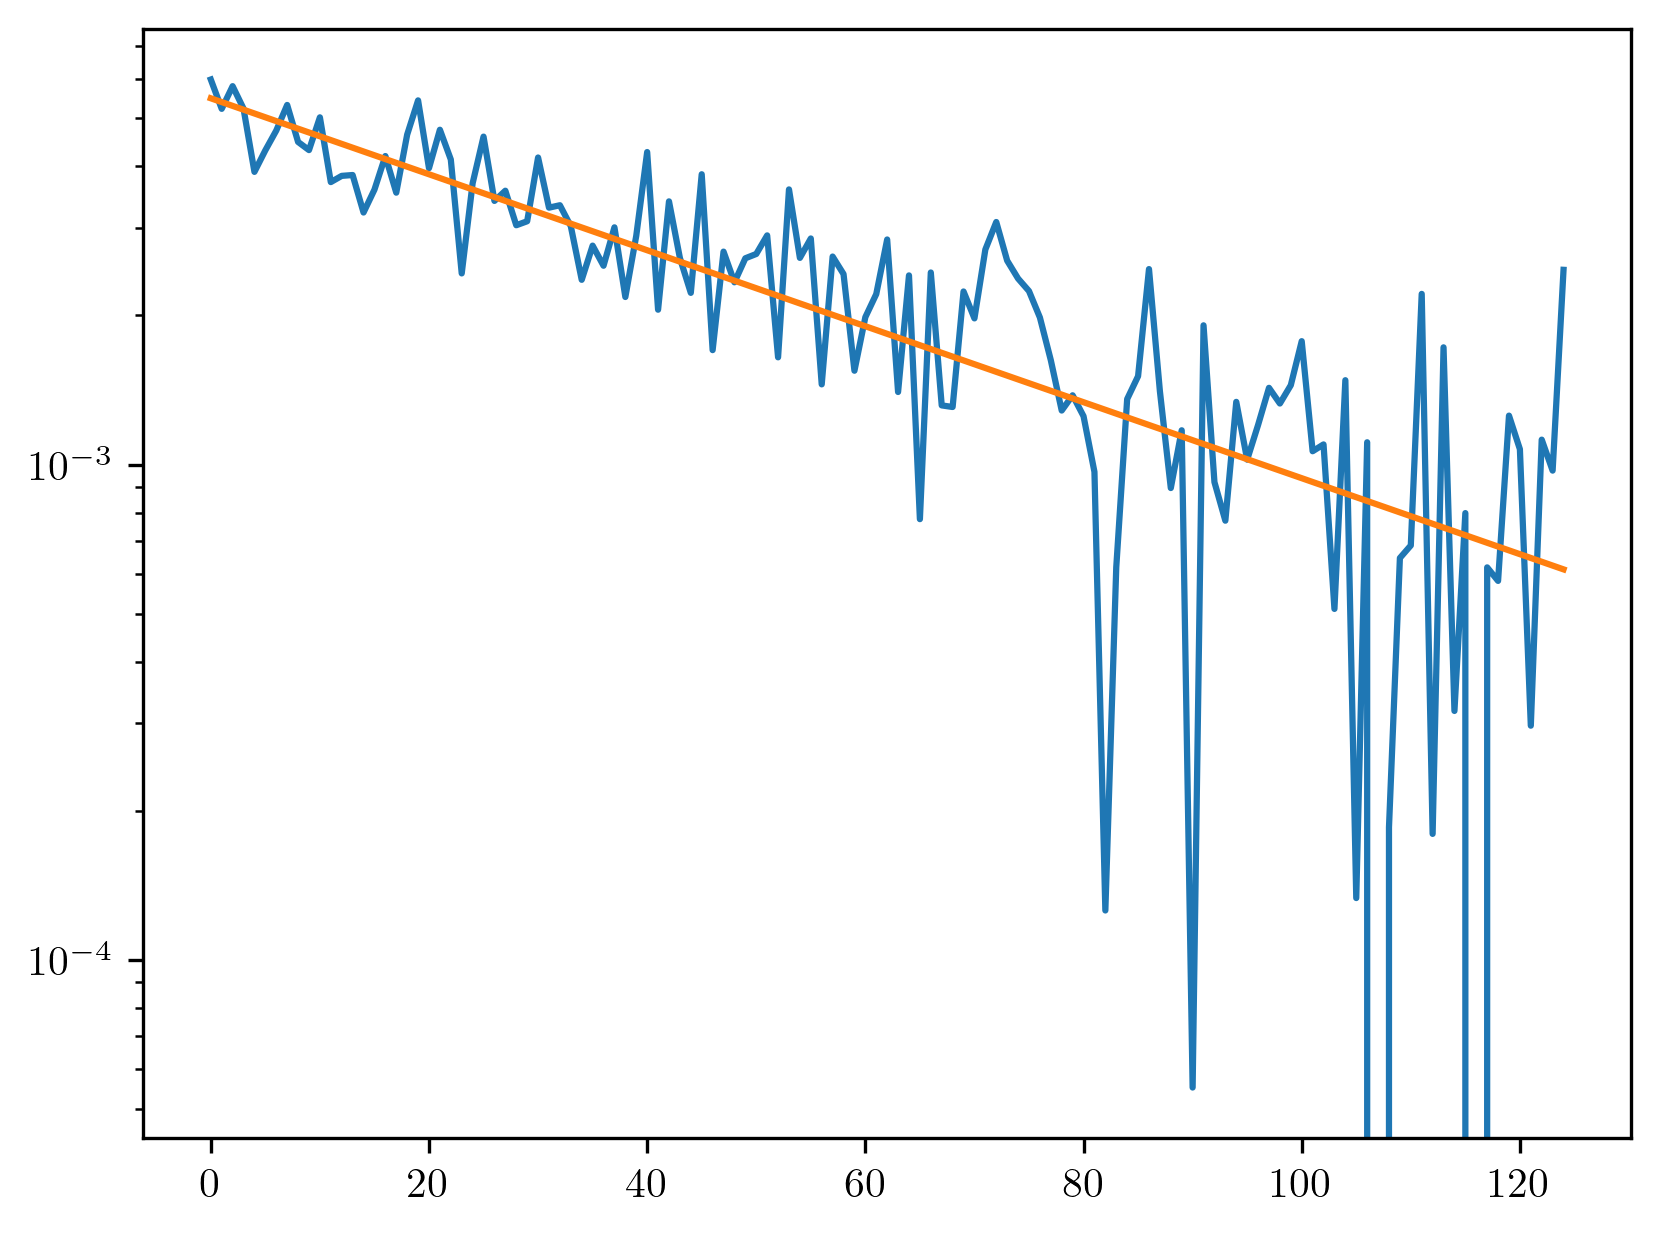

In [2]:
chippath = '../../DataKian/bTa_LT354chip3/'
filename = 'KID14_92dBm__TmK20_avgpulse_ampphase.csv' # try 92dBm and 96 of this KID, both have good pulses at all 3 wavelengths
length = 48
simtime = 300
dtinit=0.001
dxfrac=1/5

lambdasinnm = [402,673,986]

KIDdict = {}
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(showplots=True) # just to plot full pulses
for lambdanm in lambdasinnm:
    KIDdict[lambdanm] = KID_data(chippath,lambdanm,filename,length)
    KIDdict[lambdanm].fit_tail(start=175,end=300,showplots=True) # actually calculate tauqp*

In [3]:
Ls=[]
for lambdanm in lambdasinnm:
    print(KIDdict[lambdanm].tauqpstar,KIDdict[lambdanm].tauqpstarstd)
    print(KIDdict[lambdanm].L)
    Ls.append(KIDdict[lambdanm].L)
L=np.mean(Ls) # use the same linear decay rate for all wavelengths

79.76948403356127 6.282616711408312
0.012536122204065803
69.86672847214375 2.621764814932133
0.014312964437696628
56.59994383967418 4.491649792276684
0.01766786205358462


In [4]:
def prep_data(offset):
    ylist = []
    for lambdanm in lambdasinnm:
        xfit = np.arange(offset,offset+simtime-KIDdict[lambdanm].dt/2,KIDdict[lambdanm].dt)
        indmin = np.argmax(KIDdict[lambdanm].phase)+offset
        indmax = indmin + simtime
        ylist.append(KIDdict[lambdanm].phase[indmin:indmax])
    yfit = np.array(ylist).ravel()
    return xfit, yfit

def func_to_parallelize(t,params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False,approx2D=False,ringingdtinterp=0.005)
     return np.interp(t,SIM.t_axis_interp,SIM.phaseintime)

def fitfunc(t,eta,sigma1,sigma2,sigma3,tau,Q0):
    print('eta (-):\t',eta)
    print('sigma1 (um):\t',sigma1)
    print('sigma2 (um):\t',sigma2)
    print('sigma3 (um):\t',sigma3)
    print('tau (us):\t',tau)
    print('Q0 (um-1):\t',Q0)
    datalist = Parallel(n_jobs=len(lambdasinnm))(delayed(func_to_parallelize)(t,KID_params(eta_pb=eta,sigma_IC=sigma,trickle_time=tau,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm,sigma in zip(lambdasinnm,[sigma1,sigma2,sigma3]))
    return np.concatenate(datalist)

def par_func_plot(params):
     SIM = KID_sim(params,dtinit,dxfrac,simtime_approx=simtime,D_const=False,approx2D=False,ringingdtinterp=0.005)
     return SIM

def plotsim(eta,sigma1,sigma2,sigma3,tau,Q0):
    datalist = Parallel(n_jobs=len(lambdasinnm))(delayed(par_func_plot)(KID_params(eta_pb=eta,sigma_IC=sigma,trickle_time=tau,Q0=Q0,KID=KIDdict[lambdanm],L=L)) for lambdanm,sigma in zip(lambdasinnm,[sigma1,sigma2,sigma3]))
    plotdata = {}
    for obj,lambdanm in zip(datalist,lambdasinnm):
         plotdata[lambdanm]=obj
    return plotdata

In [5]:
'''xfit,yfit=prep_data(-5) #e.g. -5 means take 5 data points before the max into account for the data
p0 = [ 0.98814218132266,5,5,5,0.2833784919537387,1.0416224575485475]
popt, pcov = curve_fit(fitfunc,xfit,yfit,p0=p0,bounds=[[0.01,0.2,0.2,0.2,0.01,0.1],[1,length,length,length,10,np.inf]]) #with tau
print('\nDone!')'''

"xfit,yfit=prep_data(-5) #e.g. -5 means take 5 data points before the max into account for the data\np0 = [ 0.98814218132266,5,5,5,0.2833784919537387,1.0416224575485475]\npopt, pcov = curve_fit(fitfunc,xfit,yfit,p0=p0,bounds=[[0.01,0.2,0.2,0.2,0.01,0.1],[1,length,length,length,10,np.inf]]) #with tau\nprint('\nDone!')"

In [6]:
'''# Display parameters, standard deviation, and correlation coefficient
parameters = ['eta','sigma1','sigma2','sigma3','tau','Q0']
print("Parameters:")
for name, param, std in zip(parameters,popt,np.sqrt(np.diag(pcov))):
    print(f"{name}:\t{param:.10f}\t+/-\t{std:.10f}")

print("\nCorrelation Coefficients:")
for i in range(len(popt)):
    for j in range(i+1, len(popt)):
        print(f"{parameters[i]} vs {parameters[j]}: {pcov[i,j]/np.prod(np.sqrt(pcov[i,i]*pcov[j,j])):.10f}")'''

'# Display parameters, standard deviation, and correlation coefficient\nparameters = [\'eta\',\'sigma1\',\'sigma2\',\'sigma3\',\'tau\',\'Q0\']\nprint("Parameters:")\nfor name, param, std in zip(parameters,popt,np.sqrt(np.diag(pcov))):\n    print(f"{name}:\t{param:.10f}\t+/-\t{std:.10f}")\n\nprint("\nCorrelation Coefficients:")\nfor i in range(len(popt)):\n    for j in range(i+1, len(popt)):\n        print(f"{parameters[i]} vs {parameters[j]}: {pcov[i,j]/np.prod(np.sqrt(pcov[i,i]*pcov[j,j])):.10f}")'

In [7]:
'''
Parameters:
eta:	0.9888264866	+/-	0.0583396619
sigma1:	11.7517764996	+/-	7.9669088788
sigma2:	6.3993243092	+/-	1.5017846306
sigma3:	6.0862379608	+/-	1.8199553945
tau:	0.0521945581	+/-	0.0029749363
Q0:	5.0457097903	+/-	0.2171404678

Correlation Coefficients:
eta vs sigma1: -0.2395589742
eta vs sigma2: -0.7351097088
eta vs sigma3: -0.7116235309
eta vs tau: 0.3563879853
eta vs Q0: 0.3558644109
sigma1 vs sigma2: 0.3466476168
sigma1 vs sigma3: 0.3396849792
sigma1 vs tau: -0.9877440823
sigma1 vs Q0: -0.4981101970
sigma2 vs sigma3: 0.6743451446
sigma2 vs tau: -0.3896617972
sigma2 vs Q0: -0.6459889480
sigma3 vs tau: -0.3846072063
sigma3 vs Q0: -0.5970593466
tau vs Q0: 0.4424801599
'''

simdata = plotsim(0.9888264866,11.7517764996,6.3993243092,6.0862379608,0.0521945581,5.0457097903)

Iteration: 1323	Simtime (us): 300.57804469906337
max Teff =  0.1675669642285166
Iteration: 1609	Simtime (us): 300.46393521242004
max Teff =  0.16784248054398798
Iteration: 1787	Simtime (us): 300.57950947548085
max Teff =  0.16290652382342782


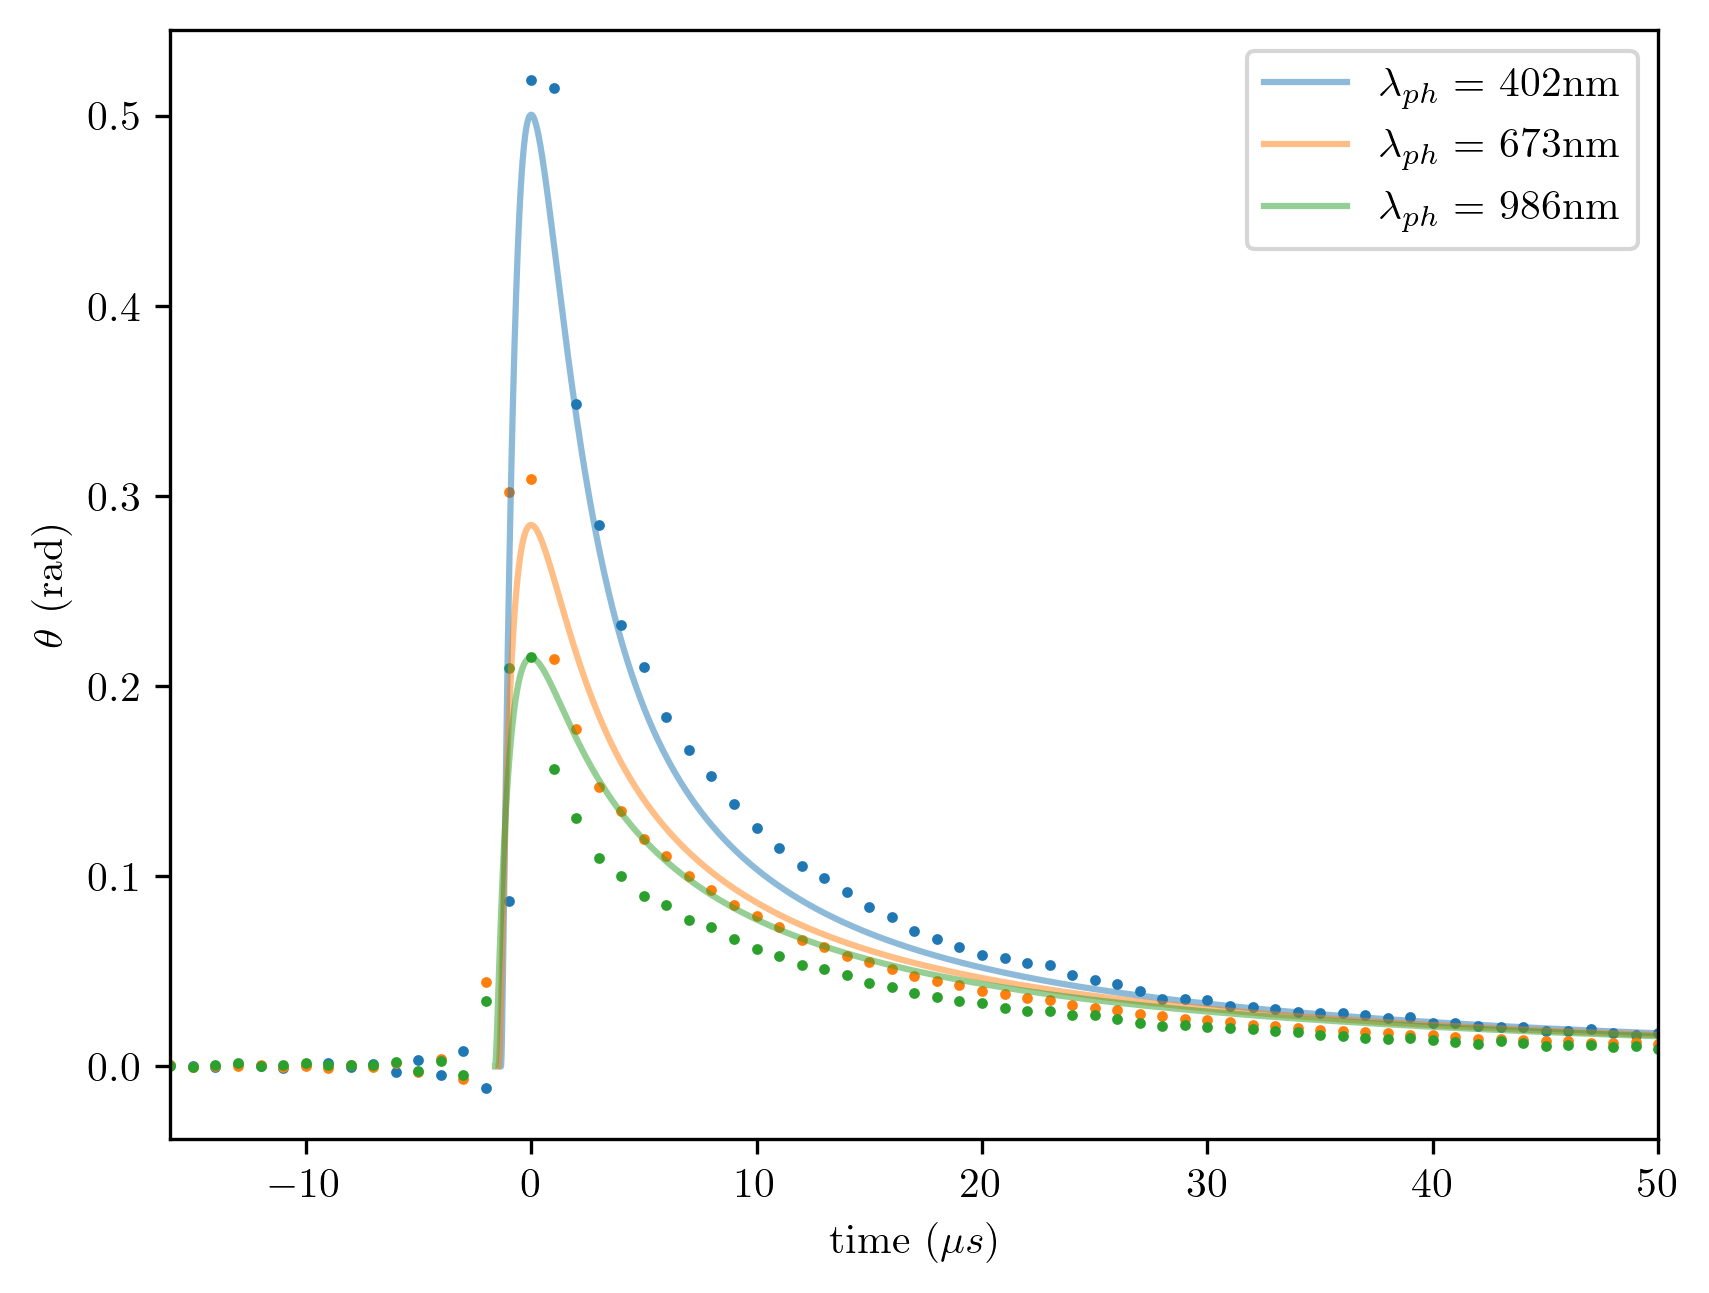

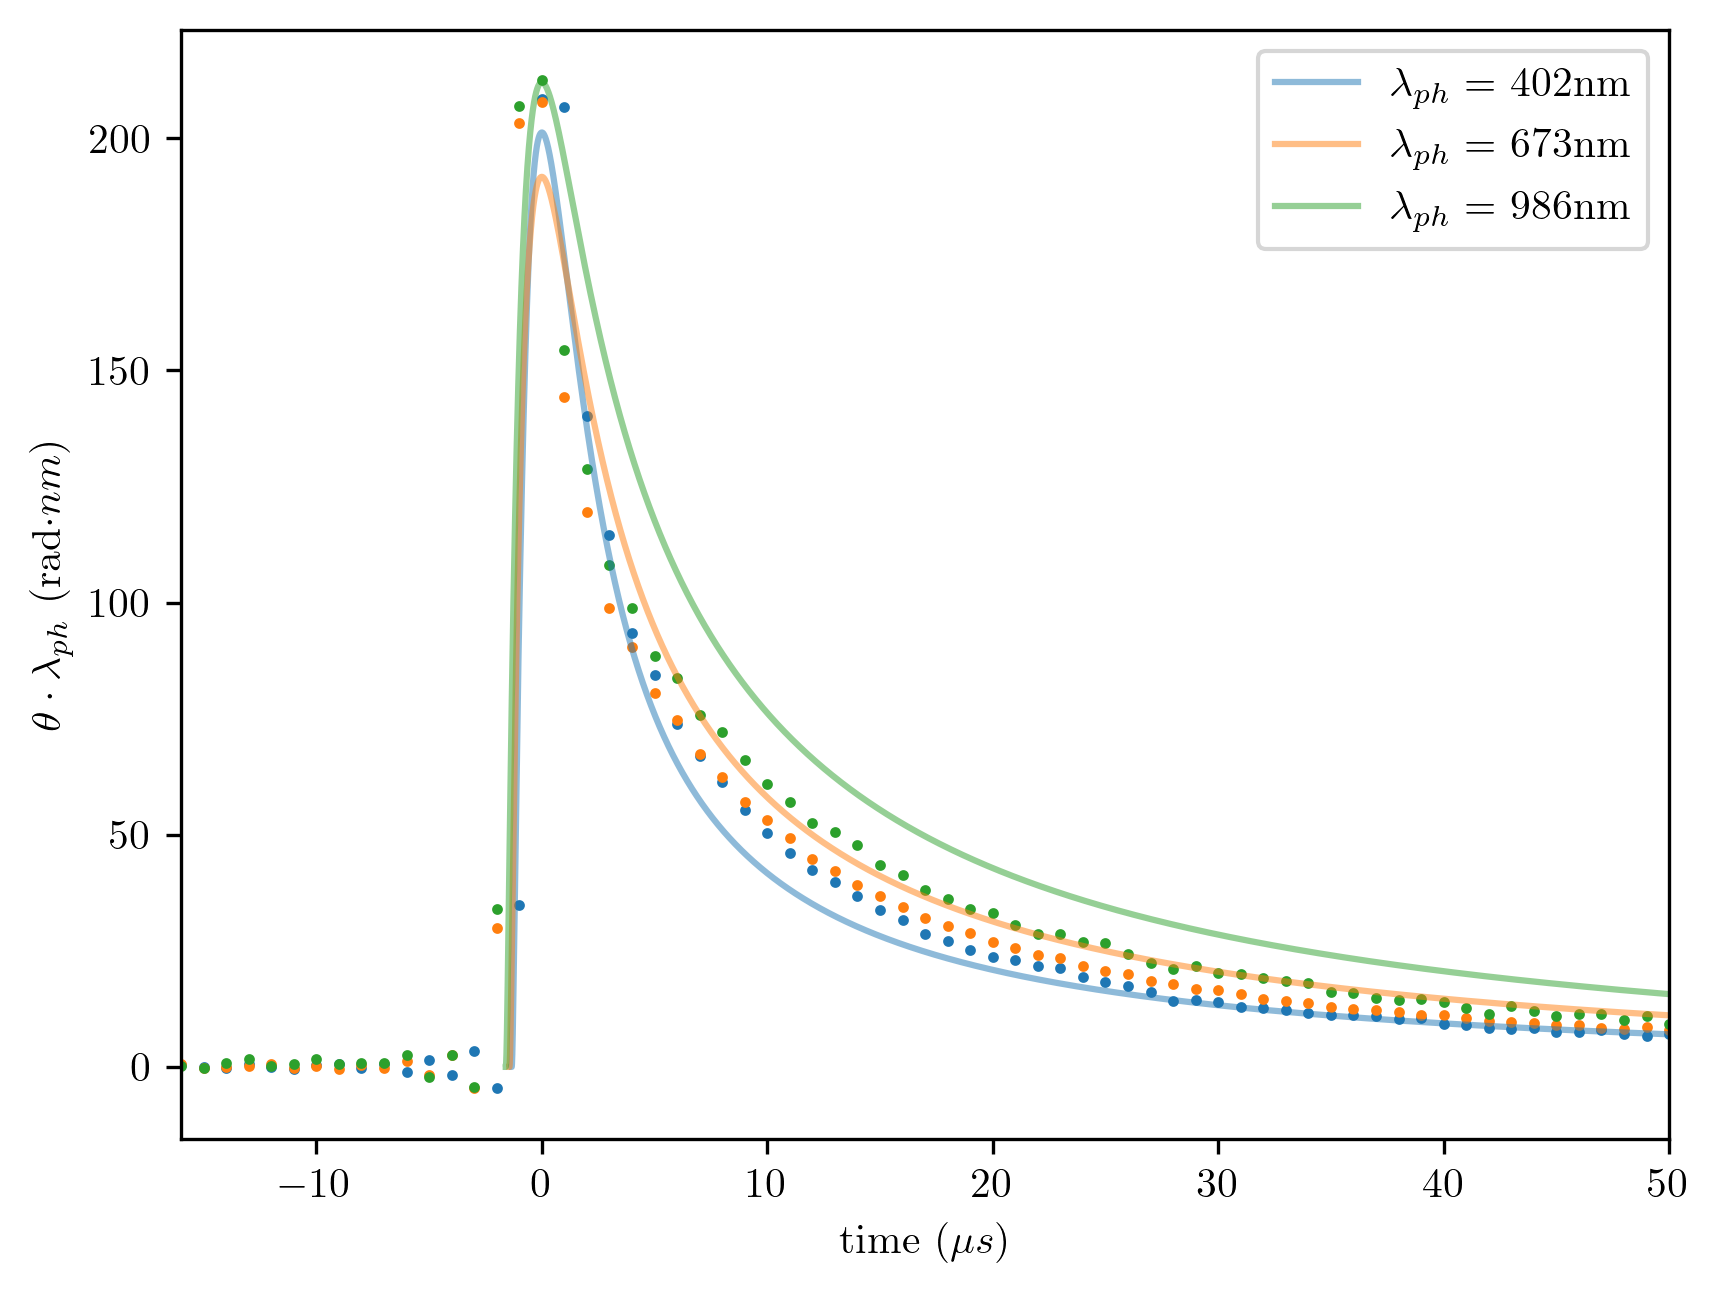

In [8]:
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime,alpha=0.5,label=r'$\lambda_{ph}=$\ '+str(lambdanm)+r'nm')
    plt.scatter(t,phase,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta$ (rad)')
#plt.ylim(1e-3)
#plt.semilogy()
plt.legend()
plt.show()
plt.figure()
for lambdanm in lambdasinnm:
    phase = KIDdict[lambdanm].phase
    t = KIDdict[lambdanm].t_full
    t -= t[np.argmax(phase)]
    plt.plot(simdata[lambdanm].t_axis_interp,simdata[lambdanm].phaseintime*lambdanm,alpha=0.5,label=r'$\lambda_{ph}=$\ '+str(lambdanm)+r'nm')
    plt.scatter(t,phase*lambdanm,marker='.',s=10)
plt.xlim(10*simdata[lambdanm].t_start,50)
plt.xlabel(r'time ($\mu s$)')
plt.ylabel(r'$\theta\cdot\lambda_{ph}$ (rad$\cdot nm$)')
#plt.ylim(1e-3)
#plt.semilogy()
plt.legend()
plt.show()